In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install keras

# Explore data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

dir_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/Data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel(dir_path + 'total_power_EV_disponible.xlsx')

In [ ]:
df.head()

,Time,total_usable_power_MW,total_usable_power_MW_profile_2,total_usable_power_MW_profile_3,total_usable_power_MW_profile_4,total_usable_power_MW_profile_5,total_usable_power_all_profiles_MW
0,2022-06-07 00:00:00,0.91,0.00,0.16,0.56,0.00,1.63
1,2022-06-07 01:00:00,0.91,0.55,0.16,0.56,0.00,2.18
2,2022-06-07 02:00:00,0.91,0.55,0.16,0.56,0.00,2.18
3,2022-06-07 03:00:00,0.91,0.55,0.16,0.56,0.00,2.18
4,2022-06-07 04:00:00,0.91,0.55,0.16,0.56,0.16,2.34


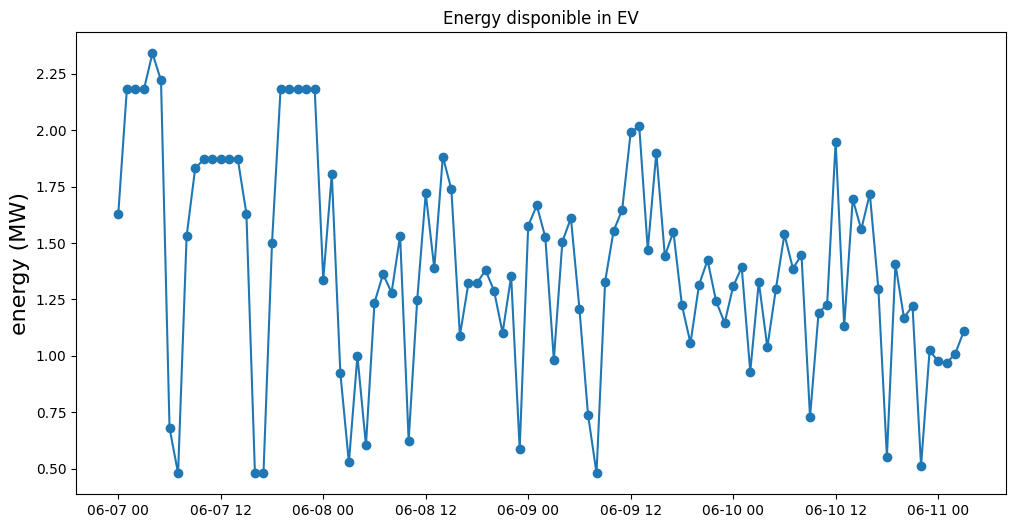

In [ ]:
plt.figure(figsize=(12, 6))
plt.title('Energy disponible in EV')
plt.ylabel('energy (MW)', fontsize=16)
plt.plot(df["Time"][:100], df['total_usable_power_all_profiles_MW'][:100], marker='o', linestyle='-')

# Search a model AI

In [ ]:
def create_dataset(serie, time_steps=1):
    Xs, ys = [], []
    for i in range(len(serie) - time_steps):
        Xs.append(serie.iloc[i:(i + time_steps)].values)
        ys.append(serie.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


In [ ]:
time_steps = 15
X, y = create_dataset(df['total_usable_power_all_profiles_MW'], time_steps)

In [ ]:

names = ["x" + str(i) for i in range(time_steps)]

print(names)


['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14']


In [ ]:
X.shape

(5238, 15)

In [ ]:
df = pd.DataFrame(X, columns=names)
df["y"] = y
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,y
0,1.63,2.18,2.18,2.18,2.34,2.22,0.68,0.48,1.53,1.83,1.87,1.87,1.87,1.87,1.87,1.63
1,2.18,2.18,2.18,2.34,2.22,0.68,0.48,1.53,1.83,1.87,1.87,1.87,1.87,1.87,1.63,0.48
2,2.18,2.18,2.34,2.22,0.68,0.48,1.53,1.83,1.87,1.87,1.87,1.87,1.87,1.63,0.48,0.48
3,2.18,2.34,2.22,0.68,0.48,1.53,1.83,1.87,1.87,1.87,1.87,1.87,1.63,0.48,0.48,1.50
4,2.34,2.22,0.68,0.48,1.53,1.83,1.87,1.87,1.87,1.87,1.87,1.63,0.48,0.48,1.50,2.18


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

In [ ]:
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping



# Normalize your data
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(-1, 1)).reshape((X.shape[0], time_steps, 1))
y = scaler.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=4800, random_state=42, shuffle=False)


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


## Simple RNN

In [ ]:
import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    model = keras.Sequential()

    # Tune number of units in RNN layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(keras.layers.SimpleRNN(hp_units, activation='relu', input_shape=(time_steps, 1)))

    # Optional: Tune dropout
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Dense(1))

    # Tune learning rate
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse', metrics=['mae'])

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,              # You can increase this for deeper search
    executions_per_trial=1,
    directory='rnn_tuning',
    project_name='rnn_time_series'
)

# Callback for early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Run the tuner search
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_test, y_test),
             callbacks=[early_stop],
             verbose=1)


Trial 10 Complete [00h 01m 07s]
val_loss: 0.03515520691871643

Best val_loss So Far: 0.03515520691871643
Total elapsed time: 00h 06m 11s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best units: {best_hps.get('units')}
Best dropout: {best_hps.get('dropout')}
Best learning rate: {best_hps.get('learning_rate')}
""")

# Build and train best model
model_best_rnn = tuner.hypermodel.build(best_hps)

history_best_rnn = model_best_rnn.fit(X_train, y_train,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[early_stop])



Best units: 256
Best dropout: 0.4
Best learning rate: 0.0001

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.1152 - mae: 0.2764 - val_loss: 0.0405 - val_mae: 0.1684
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0449 - mae: 0.1746 - val_loss: 0.0367 - val_mae: 0.1593
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0440 - mae: 0.1743 - val_loss: 0.0367 - val_mae: 0.1600
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0430 - mae: 0.1712 - val_loss: 0.0363 - val_mae: 0.1586
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0440 - mae: 0.1745 - val_loss: 0.0371 - val_mae: 0.1626
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0422 - mae: 0.1714 - val_loss: 0.0364 - val_mae: 0.1611
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0427 - mae: 0.1718 - val_loss: 0.0375 - val_mae: 0.1644
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0412 - mae: 0.1686 - val_loss: 0.

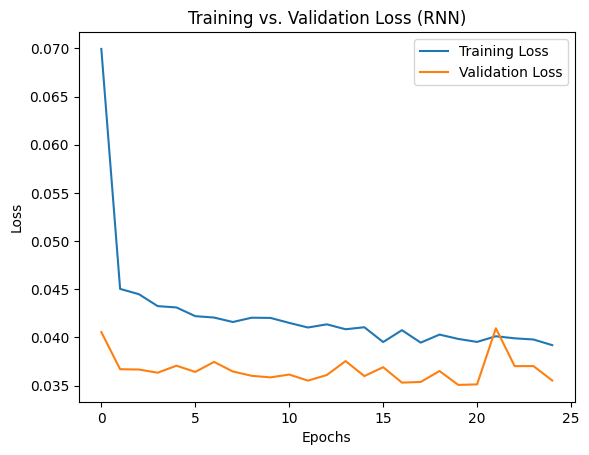

In [ ]:
plt.plot(history_best_rnn.history['loss'], label='Training Loss')
plt.plot(history_best_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


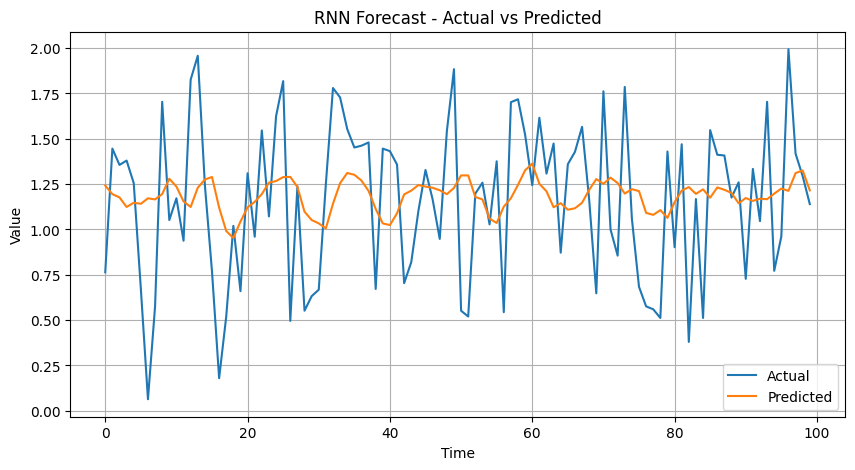

In [ ]:
best_predictions_rnn = model_best_rnn.predict(X_test)

# Convert from normalized back to real values
best_y_pred_inverse = scaler.inverse_transform(best_predictions_rnn)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(best_y_pred_inverse[:100], label='Predicted')
plt.title("RNN Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# evaluate
from sklearn.metrics import r2_score, mean_absolute_error

r2_rnn = r2_score(y_test_inverse, best_y_pred_inverse)
mae_rnn = mean_absolute_error(y_test_inverse, best_y_pred_inverse)

print("RNN")
print(f"R2 Score: {r2_rnn}")
print(f"MAE: {mae_rnn}")

RNN
R2 Score: 0.04893524817456074
MAE: 0.3464598746898511


In [ ]:
print(best_hps.values)


{'units': 256, 'dropout': 0.4, 'learning_rate': 0.0001}


## LSTM

In [ ]:
# Build LSTM model function for tuning
def build_model_lstm(hp):
    model = keras.Sequential()

    for i in range(hp.Int("num_layers", 2, 3)):
        return_seq = i < hp.get("num_layers") - 1
        model.add(keras.layers.LSTM(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            return_sequences=return_seq,
            activation=hp.Choice(f'activation_{i}', values=['tanh', 'relu']),
            input_shape=(time_steps, 1) if i == 0 else None
        ))
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(keras.layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])),
        loss='mse',
        metrics=['mae']
    )

    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model_lstm,  # or change to other models (e.g., build_model_bilstm)
    objective='val_loss',
    max_trials=20,  # Increase trials for better search
    directory='tuner_dir',
    project_name='best_model'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

# Get the best hyperparameters and build the model
best_hp = tuner.get_best_hyperparameters(1)[0]
model_LSTM = tuner.hypermodel.build(best_hp)

# Train the model with the best hyperparameters
history_lstm = model_LSTM.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])


Reloading Tuner from tuner_dir/best_model/tuner0.json
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.2240 - mae: 0.3203 - val_loss: 0.0374 - val_mae: 0.1572
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0408 - mae: 0.1667 - val_loss: 0.0372 - val_mae: 0.1603
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0407 - mae: 0.1674 - val_loss: 0.0401 - val_mae: 0.1584
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0404 - mae: 0.1667 - val_loss: 0.0369 - val_mae: 0.1571
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0407 - mae: 0.1666 - val_loss: 0.0382 - val_mae: 0.1642
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0400 - mae: 0.1661 - val_loss: 0.0376 - val_mae: 0.1563
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0413 - mae: 0.1681 - val_loss: 0.0368 - val_mae: 0.1563
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0387 - mae: 0.1637 - val_loss: 0.0363 - val_mae: 0.1585
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/ste

In [ ]:
# best parameters
print(best_hp.values)


{'num_layers': 2, 'units_0': 64, 'activation_0': 'tanh', 'dropout_0': 0.4, 'units_1': 256, 'activation_1': 'relu', 'dropout_1': 0.2, 'learning_rate': 0.01, 'units_2': 256, 'activation_2': 'relu', 'dropout_2': 0.30000000000000004}


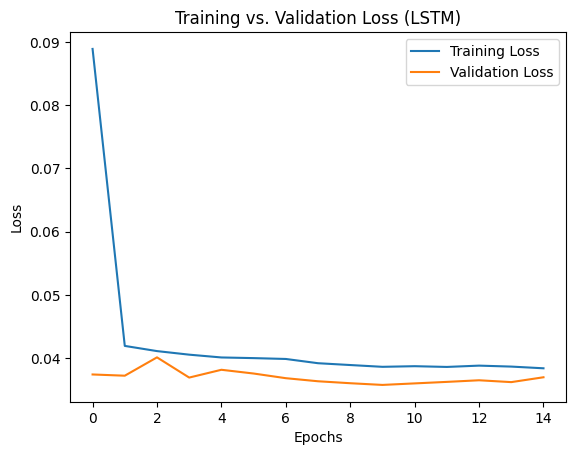

In [ ]:
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


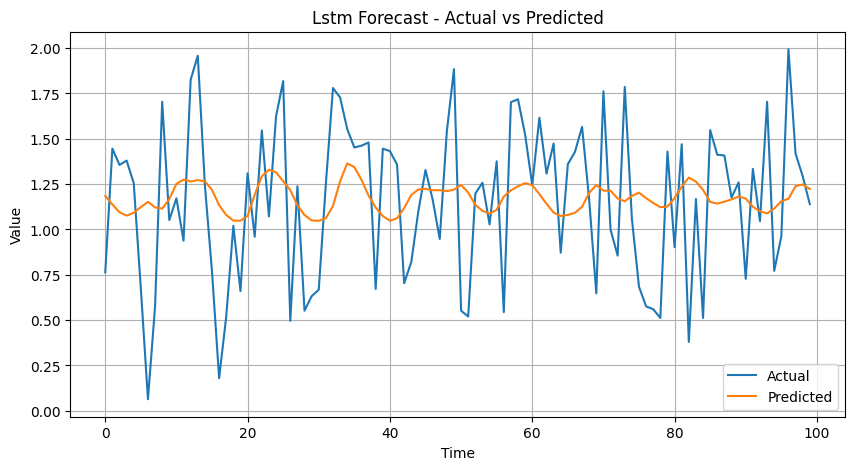

In [ ]:
predictions_lstm = model_LSTM.predict(X_test)

# Convert from normalized back to real values
lstm_y_pred_inverse = scaler.inverse_transform(predictions_lstm)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(lstm_y_pred_inverse[:100], label='Predicted')
plt.title("Lstm Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# evaluate
from sklearn.metrics import r2_score, mean_absolute_error

r2_lstm = r2_score(y_test_inverse, lstm_y_pred_inverse)
mae_lstm = mean_absolute_error(y_test_inverse, lstm_y_pred_inverse)

print("LSTM")
print(f"R2 Score: {r2_lstm}")
print(f"MAE: {mae_lstm}")

LSTM
R2 Score: 0.030062693479428915
MAE: 0.352243991044014


## BI-LSTM

In [ ]:
def build_bilstm_model(hp):
    model = keras.Sequential()

    # Add Bidirectional LSTM layers
    for i in range(hp.Int("num_layers", 1, 3)):  # Allowing 1 or 2 BiLSTM layers
        return_seq = i < hp.get("num_layers") - 1
        units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=64)
        activation = hp.Choice(f'activation_{i}', ['tanh', 'relu'])

        if i == 0:
            model.add(keras.layers.Bidirectional(
                keras.layers.LSTM(units=units, return_sequences=return_seq, activation=activation),
                input_shape=(time_steps, 1)
            ))
        else:
            model.add(keras.layers.Bidirectional(
                keras.layers.LSTM(units=units, return_sequences=return_seq, activation=activation)
            ))

        # Dropout after each BiLSTM layer
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(keras.layers.Dense(1))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])
        ),
        loss='mse',
        metrics=['mae']
    )

    return model


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_bilstm_model,
    objective='val_loss',
    max_trials=20,
    directory='bilstm_tuner_dir',
    project_name='bilstm_model'
)

# Start search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

# Get best model
best_hp = tuner.get_best_hyperparameters(1)[0]
best_bilstm_model = tuner.hypermodel.build(best_hp)
print(best_hp.values)

# Train final model
history_bilstm = best_bilstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])


Trial 20 Complete [00h 00m 45s]
val_loss: 0.03559276834130287

Best val_loss So Far: 0.0349324606359005
Total elapsed time: 01h 22m 08s
{'num_layers': 3, 'units_0': 64, 'activation_0': 'relu', 'dropout_0': 0.2, 'learning_rate': 0.0005, 'units_1': 128, 'activation_1': 'tanh', 'dropout_1': 0.1, 'units_2': 128, 'activation_2': 'relu', 'dropout_2': 0.4}
Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - loss: 0.0873 - mae: 0.2360 - val_loss: 0.0375 - val_mae: 0.1586
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0438 - mae: 0.1735 - val_loss: 0.0369 - val_mae: 0.1589
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - loss: 0.0444 - mae: 0.1743 - val_loss: 0.0369 - val_mae: 0.1594
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - loss: 0.0427 - mae: 0.1706 - val_loss: 0.0368 - val_mae: 0.1593
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.0412 - mae: 0.1667 - val_loss: 0.0369 - val_mae: 0.1599
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11

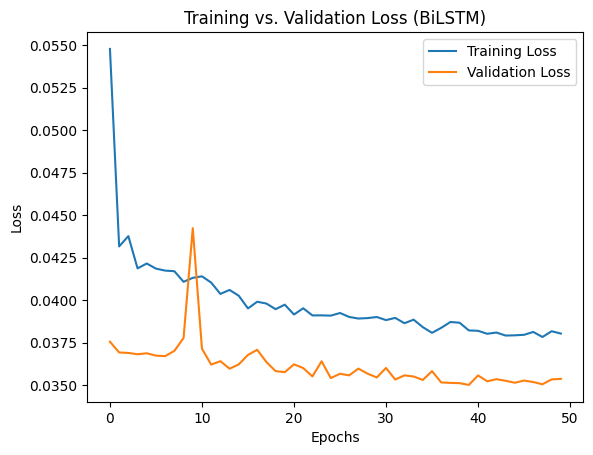

In [ ]:
plt.plot(history_bilstm.history['loss'], label='Training Loss')
plt.plot(history_bilstm.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (BiLSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


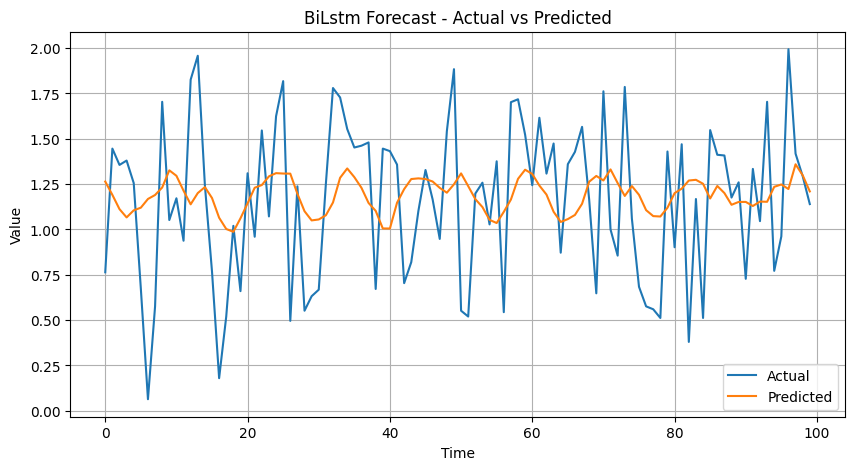

In [ ]:
predictions_bilstm = best_bilstm_model.predict(X_test)

# Convert from normalized back to real values
bilstm_y_pred_inverse = scaler.inverse_transform(predictions_bilstm)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(bilstm_y_pred_inverse[:100], label='Predicted')
plt.title("BiLstm Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# evaluate
from sklearn.metrics import r2_score, mean_absolute_error

r2_bilstm = r2_score(y_test_inverse, bilstm_y_pred_inverse)
mae_bilstm = mean_absolute_error(y_test_inverse, bilstm_y_pred_inverse)

print("BI-LSTM")
print(f"R2 Score: {r2_bilstm}")
print(f"MAE: {mae_bilstm}")

BI-LSTM
R2 Score: 0.050431267967646076
MAE: 0.349354314896614


## GRU

In [ ]:
import keras_tuner as kt
from tensorflow import keras

def build_gru_model(hp):
    model = keras.Sequential()

    # Add GRU layers
    for i in range(hp.Int("num_layers", 1, 3)):  # 1 or 2 layers
        return_seq = i < hp.get("num_layers") - 1
        units = hp.Int(f'units_{i}', min_value=64, max_value=256, step=64)
        activation = hp.Choice(f'activation_{i}', ['tanh', 'relu'])

        if i == 0:
            model.add(keras.layers.GRU(
                units=units,
                return_sequences=return_seq,
                activation=activation,
                input_shape=(time_steps, 1)
            ))
        else:
            model.add(keras.layers.GRU(
                units=units,
                return_sequences=return_seq,
                activation=activation
            ))

        # Optional dropout
        model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(keras.layers.Dense(1))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])
        ),
        loss='mse',
        metrics=['mae']
    )

    return model

# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# GRU model tuner
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=20,
    directory='gru_tuner_dir',
    project_name='gru_model'
)

# Perform search
tuner_gru.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

# Retrieve best model
best_hp_gru = tuner_gru.get_best_hyperparameters(1)[0]
best_gru_model = tuner_gru.hypermodel.build(best_hp_gru)
print(best_hp_gru.values)


# Final training
history_gru = best_gru_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])


Trial 20 Complete [00h 01m 24s]
val_loss: 0.03532767295837402

Best val_loss So Far: 0.035148803144693375
Total elapsed time: 00h 45m 42s
{'num_layers': 3, 'units_0': 128, 'activation_0': 'relu', 'dropout_0': 0.30000000000000004, 'learning_rate': 0.001, 'units_1': 128, 'activation_1': 'relu', 'dropout_1': 0.4, 'units_2': 64, 'activation_2': 'tanh', 'dropout_2': 0.1}
Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0711 - mae: 0.2092 - val_loss: 0.0387 - val_mae: 0.1570
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0421 - mae: 0.1691 - val_loss: 0.0375 - val_mae: 0.1565
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0404 - mae: 0.1653 - val_loss: 0.0370 - val_mae: 0.1567
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0407 - mae: 0.1662 - val_loss: 0.0366 - val_mae: 0.1573
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0397 - mae: 0.1645 - val_loss: 0.0378 - val_mae: 0.1562
Epoch 6/100
150/150 ━━━━━━━

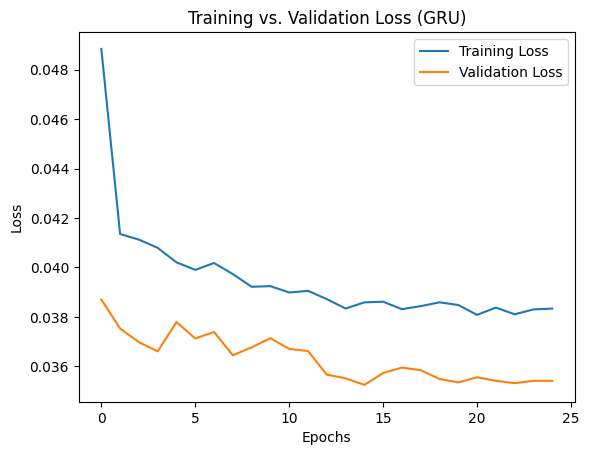

In [ ]:
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


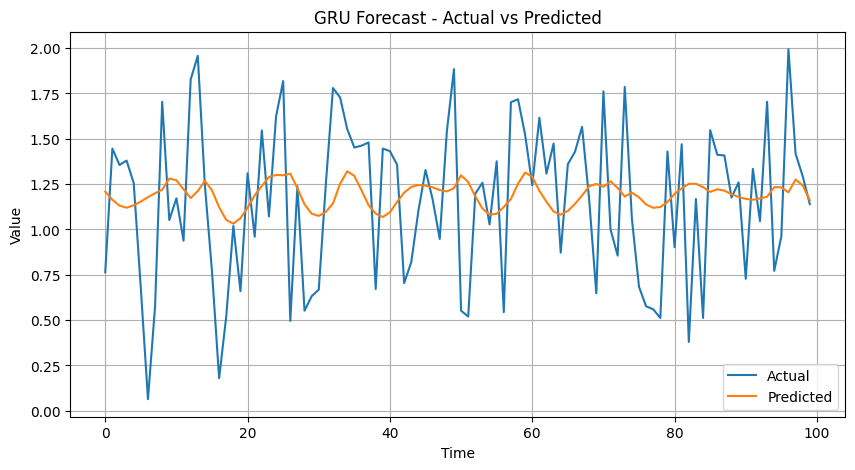

In [ ]:
predictions_gru = best_gru_model.predict(X_test)

# Convert from normalized back to real values
gru_y_pred_inverse = scaler.inverse_transform(predictions_gru)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(gru_y_pred_inverse[:100], label='Predicted')
plt.title("GRU Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# evaluate
from sklearn.metrics import r2_score, mean_absolute_error

r2_gru = r2_score(y_test_inverse, gru_y_pred_inverse)
mae_gru = mean_absolute_error(y_test_inverse, gru_y_pred_inverse)

print("GRU")
print(f"R2 Score: {r2_gru}")
print(f"MAE: {mae_gru}")

GRU
R2 Score: 0.04377990015302058
MAE: 0.348559499363921


## Hybrid Model

In [ ]:
from tensorflow import keras
import keras_tuner as kt

def build_model_hybrid(hp):
    model = keras.Sequential()

    # Conv1D layer for feature extraction (optional but powerful)
    model.add(keras.layers.Conv1D(
        filters=hp.Int('filters', 32, 128, step=32),
        kernel_size=hp.Choice('kernel_size', [2, 3, 5]),
        activation='relu',
        input_shape=(time_steps, 1)
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(hp.Float('conv_dropout', 0.1, 0.4, step=0.1)))

    # Bidirectional LSTM layer
    model.add(keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=hp.Int('lstm_units', 64, 256, step=64),
            return_sequences=True,
            activation='tanh'
        )
    ))
    model.add(keras.layers.Dropout(hp.Float('lstm_dropout', 0.1, 0.4, step=0.1)))

    # GRU layer
    model.add(keras.layers.GRU(
        units=hp.Int('gru_units', 64, 256, step=64),
        return_sequences=False,
        activation='tanh'
    ))
    model.add(keras.layers.Dropout(hp.Float('gru_dropout', 0.1, 0.4, step=0.1)))

    # Dense Block
    for i in range(hp.Int('dense_blocks', 1, 2)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'dense_units_{i}', 64, 256, step=64),
            activation='relu'
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(hp.Float(f'dense_dropout_{i}', 0.1, 0.5, step=0.1)))

    # Output layer
    model.add(keras.layers.Dense(1))

    # Compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 5e-4])
        ),
        loss='mse',
        metrics=['mae']
    )

    return model



tuner_hybrid = kt.RandomSearch(
    build_model_hybrid,
    objective='val_loss',
    max_trials=30,
    directory='hybrid_tuner_dir',
    project_name='hybrid_model'
)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Start tuning
tuner_hybrid.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])

# Build best model
best_hp_hybrid = tuner_hybrid.get_best_hyperparameters(1)[0]
best_hybrid_model = tuner_hybrid.hypermodel.build(best_hp_hybrid)
print(best_hp_hybrid.values)

# Final training
history_hybrid = best_hybrid_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop])


Trial 30 Complete [00h 07m 42s]
val_loss: 0.03607885539531708

Best val_loss So Far: 0.0348966084420681
Total elapsed time: 06h 36m 14s
{'filters': 128, 'kernel_size': 3, 'conv_dropout': 0.4, 'lstm_units': 64, 'lstm_dropout': 0.4, 'gru_units': 64, 'gru_dropout': 0.30000000000000004, 'dense_blocks': 2, 'dense_units_0': 192, 'dense_dropout_0': 0.1, 'learning_rate': 0.01, 'dense_units_1': 192, 'dense_dropout_1': 0.4}
Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 1.5140 - mae: 0.7487 - val_loss: 0.0390 - val_mae: 0.1664
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0525 - mae: 0.1878 - val_loss: 0.0386 - val_mae: 0.1665
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0518 - mae: 0.1845 - val_loss: 0.0397 - val_mae: 0.1649
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.0666 - mae: 0.2079 - val_loss: 0.0443 - val_mae: 0.1792
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0603 - mae: 0.1982 - val_loss: 0.0451

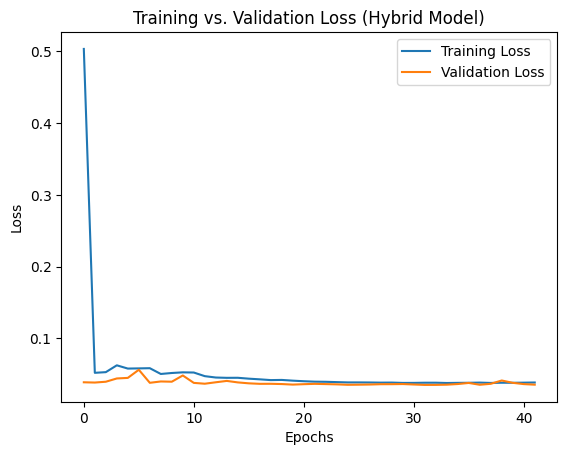

In [ ]:
plt.plot(history_hybrid.history['loss'], label='Training Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss (Hybrid Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
predictions_hybrid = best_hybrid_model.predict(X_test)

# Convert from normalized back to real values
hybrid_y_pred_inverse = scaler.inverse_transform(predictions_hybrid)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inverse[:100], label='Actual')
plt.plot(hybrid_y_pred_inverse[:100], label='Predicted')
plt.title("Hybrid Forecast - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# evaluate
from sklearn.metrics import r2_score, mean_absolute_error

r2_hybrid = r2_score(y_test_inverse, hybrid_y_pred_inverse)
mae_hybrid = mean_absolute_error(y_test_inverse, hybrid_y_pred_inverse)

print("Hybrid")
print(f"R2 Score: {r2_hybrid}")
print(f"MAE: {mae_hybrid}")

# Comparaison

In [ ]:
import pandas as pd

# Create a dictionary with the performance metrics for each model
model_performance = {
    'Model': ['LSTM', 'RNN', 'GRU','Hybrid','Bi-LSTM'],
    'MAE': [mae_lstm, mae_rnn, mae_gru,mae_hybrid,mae_bilstm],
    'R2': [r2_lstm, r2_rnn, r2_gru,r2_hybrid,r2_bilstm]
}

performance = pd.DataFrame(model_performance)
performance

In [ ]:
import joblib

# Find the best model by R2 score
best_model_name = performance.loc[performance['R2'].idxmax(), 'Model']
print(f"Best model: {best_model_name}")

# Dictionary mapping model names to actual model objects
model_dict = {
    'LSTM': model_LSTM,
    'RNN': model_best_rnn,
    'GRU': best_gru_model,
    'Hybrid': best_hybrid_model,
    'Bi-LSTM': best_bilstm_model
}

best_model = model_dict[best_model_name]
dir_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/New_best_model/'

model_best_rnn.save(f"{dir_path}{best_model_name}_Cars_v2g.h5")

In [ ]:
# the best model is RNN

dir_path = '/content/drive/MyDrive/Colab Notebooks/TS_Project_V2G/New_best_model/'
model_best_rnn.save(f"{dir_path}{best_model_name}_Cars_v2g.h5")